In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import gensim
from gensim.models import Word2Vec

# Narrative Exploratory Data Analysis

Exploratory data analysis of APHIS inspection reports data's "narrative" column. 

In [2]:
combined_dir = '../aphis-inspection-reports/data/combined/'

In [3]:
narratives = pd.read_csv(combined_dir + 'inspections-narratives.csv')
print(narratives.shape)
narratives.columns.tolist()

(94883, 2)


['hash_id', 'narrative']

In [4]:
species = pd.read_csv(combined_dir + 'inspections-species.csv')
print(species.shape)
species.columns.tolist()

(398528, 4)


['hash_id', 'count', 'scientific', 'common']

In [5]:
species['scientific'].value_counts().head(10)

scientific
Canis lupus familiaris    51841
Oryctolagus cuniculus     13297
Capra hircus              13055
Ovis aries aries           9605
Sus scrofa domestica       9317
Cavia porcellus            7530
Bos taurus                 6543
Atelerix albiventris       6031
Lama glama                 5755
Lemur catta                5591
Name: count, dtype: int64

In [6]:
species['common'].value_counts().head(15)

common
DOG ADULT                                  30285
DOG PUPPY                                  24440
DOMESTIC GOAT                              13051
SHEEP INCLUDING ALL DOMESTIC BREEDS         9604
DOMESTIC PIG / POTBELLY PIG / MICRO PIG     9314
DOMESTIC RABBIT / EUROPEAN RABBIT           8883
DOMESTIC GUINEA PIG                         7529
CATTLE / COW / OX / WATUSI                  6539
LLAMA                                       5755
ALPACA                                      5477
RING-TAILED LEMUR                           5347
EUROPEAN RABBIT                             4400
BOBCAT                                      4097
TIGER                                       4058
RED KANGAROO                                3683
Name: count, dtype: int64

In [7]:
citations = pd.read_csv(combined_dir + 'inspections-citations.csv')
print(citations.shape)
citations.columns.tolist()

(38749, 6)


['hash_id', 'code', 'kind', 'repeat', 'desc', 'narrative']

In [8]:
citations['kind'].value_counts(dropna=False)

kind
NaN         35603
Direct       1959
Critical     1187
Name: count, dtype: int64

In [9]:
inspections = pd.read_csv(combined_dir + 'inspections.csv')
print(inspections.shape)
inspections.columns.tolist()

(95459, 31)


/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/2060818130.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  inspections = pd.read_csv(combined_dir + 'inspections.csv')


['web_certNumber',
 'web_certType',
 'web_city',
 'web_critical',
 'web_customerNumber',
 'web_direct',
 'web_inspectionDate',
 'web_legalName',
 'web_nonCritical',
 'web_reportLink',
 'web_siteName',
 'web_state',
 'web_teachableMoments',
 'web_zip',
 'hash_id',
 'discovered',
 'pdf_insp_id',
 'pdf_layout',
 'pdf_customer_id',
 'pdf_customer_name',
 'pdf_customer_addr',
 'pdf_certificate',
 'pdf_site_id',
 'pdf_site_name',
 'pdf_insp_type',
 'pdf_date',
 'pdf_report_date',
 'pdf_animals_total',
 'doccloud_url',
 'licenseType',
 'customer_state']

In [10]:
# Overview of all column values
for i in inspections.columns.tolist(): 
    print(inspections[i].value_counts())
    print('------------------------')
    print()

web_certNumber
33-T-0011    478
57-T-0001    454
74-T-0007    442
87-T-0003    292
91-T-0001    251
            ... 
84-A-0187      1
58-C-1050      1
58-C-1286      1
63-B-0196      1
33-A-0628      1
Name: count, Length: 14083, dtype: int64
------------------------

web_certType
Class A - Breeder                               32659
Class C - Exhibitor                             31514
Class R - Research Facility                     12475
Class B - Dealer                                10037
Class T - Carrier                                5857
Class H - Intermediate Handler                   1144
Class G - Agricultural Research Facility ARS      357
Class F - Federal Research Facility                38
Class E - Exhibitor                                 1
Class V - Veteran's Administration Hospital         1
Name: count, dtype: int64
------------------------

web_city
MILLERSBURG         876
CHICAGO             712
SAN FRANCISCO       614
MONTGOMERY          520
LAS VEGAS           4

In [11]:
# Joining inspections and citations 
inspections_citations = inspections.merge(citations, how='left', on='hash_id')
inspections_citations = inspections_citations.drop_duplicates(subset=['hash_id'])
inspections_citations.shape

(94855, 36)

In [12]:
# Overview of all column values
for i in inspections_citations.columns.tolist(): 
    print(inspections_citations[i].value_counts())
    print('------------------------')
    print()

web_certNumber
33-T-0011    474
57-T-0001    451
74-T-0007    438
87-T-0003    292
91-T-0001    251
            ... 
34-T-0039      1
31-A-0285      1
31-A-0921      1
63-B-0196      1
33-A-0628      1
Name: count, Length: 14083, dtype: int64
------------------------

web_certType
Class A - Breeder                               32621
Class C - Exhibitor                             31499
Class R - Research Facility                     12444
Class B - Dealer                                10025
Class T - Carrier                                5850
Class H - Intermediate Handler                   1143
Class G - Agricultural Research Facility ARS      357
Class F - Federal Research Facility                38
Class E - Exhibitor                                 1
Class V - Veteran's Administration Hospital         1
Name: count, dtype: int64
------------------------

web_city
MILLERSBURG      876
CHICAGO          712
SAN FRANCISCO    614
MONTGOMERY       520
LAS VEGAS        495
            

In [13]:
inspections_citations['web_siteName'].value_counts(dropna=False)

web_siteName
DELTA AIRLINES INC          351
AMERICAN AIRLINES INC.      271
ALASKA AIRLINES             231
ENDEAVOR AIR INC            183
VARIOUS TRAVEL LOCATIONS    145
                           ... 
WAGGINGDOG TRANSPORT INC      1
ATTENTION OWNER               1
Joan Powers                   1
EVAN BLOCK                    1
Sunset Pawbabies              1
Name: count, Length: 15054, dtype: int64

In [14]:
inspections_citations['web_siteName'].isnull().sum()

1

In [15]:
inspections_citations['narrative'].notnull().sum()

21082

In [16]:
inspections_citations[inspections_citations['narrative'].notnull()]['pdf_insp_type'].value_counts()

pdf_insp_type
ROUTINE INSPECTION       13229
ATTEMPTED INSPECTION      6727
FOCUSED INSPECTION         668
RE-LICENSE INSPECTION      417
NEW SITE INSPECTION         41
Name: count, dtype: int64

In [17]:
# web_critical = Number of "critical" noncompliant items
inspections_citations[inspections_citations['narrative'].notnull()]['web_critical'].value_counts()

web_critical
0    19711
1     1145
2      162
3       44
4       14
5        4
6        1
8        1
Name: count, dtype: int64

In [18]:
# web_direct = Number of "direct" noncompliant items
inspections_citations[inspections_citations['narrative'].notnull()]['web_direct'].value_counts()

web_direct
0     19705
1      1039
2       218
3        61
4        30
5        16
7         4
6         4
8         3
9         1
14        1
Name: count, dtype: int64

In [19]:
inspections_citations[(inspections_citations['narrative'].notnull()) & (inspections_citations['web_direct']== 0)]['narrative'].head(5).tolist()

['At the south farm, a goat was observed to jump up onto the ledge of the concrete foundation and move from pen 4\nover to pen 5 and then back to pen 4 again. There was a panel up on the ledge in place to prevent this, however\nthe goat could pass between the vertical supports of the panel. Also, the panel had some free ends of wire that if\nbent out could become sharp points exposed to any goat that climbs up on the concrete ledge. Lack of proper\ncontainment and exposure to sharp points could lead to injury or other adverse events. The facility must ensure\nthat enclosures are structurally sound and maintained in good repair to contain the animals and protect them from\ninjury.\nCorrect by October 5, 2016.\nThis inspection and exit interview were conducted with facility representatives on 9/26 thru 9/27/2016.',
 'Two bottles of Heparin (one partially used, one unopened) and one partially used tube of Puralube eye lubrication\nointment were found in room 140 at ATRC building that were

## Word Frequencies

Looking at most frequently occuring words in "narrative" column. 

In [20]:
inspections_citations_notnull = inspections_citations[inspections_citations['narrative'].notnull()]

In [21]:
# Load NLTK stopwords
stop_words = set(stopwords.words("english"))

# Combine all text from the 'text_column' into a single string
all_text = ' '.join(inspections_citations_notnull['narrative'].apply(lambda x: x.lower()))

# Tokenize the combined text
tokens = word_tokenize(all_text)

# Remove stopwords
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_tokens)

# Get the most common words
most_common_words = word_counts.most_common()

print("Most Frequent Words:")
for word, count in most_common_words[0:50]:
    print(f"{word}: {count}")

Most Frequent Words:
.: 124860
,: 75804
inspection: 26216
animals: 20077
facility: 19007
licensee: 16390
must: 15031
*: 14139
animal: 13597
): 13000
(: 12694
available: 11959
care: 11353
veterinarian: 11149
adult: 10349
aphis: 9443
veterinary: 9017
conducted: 8474
enclosure: 8157
officials: 8110
responsible: 8087
correct: 7931
accompany: 7794
:: 7784
process: 7739
exit: 7294
ensure: 6680
attending: 6433
dogs: 6346
records: 5987
one: 5590
health: 5544
dog: 5526
program: 5466
inspector: 5439
interview: 5212
enclosures: 5206
section: 5139
time: 5118
shall: 4918
left: 4873
treatment: 4714
corrected: 4685
may: 4492
two: 4045
could: 3985
's: 3904
representative: 3782
area: 3703
#: 3696


## TFIDF

Looking at most important words in "narrative" column based on term frequency–inverse document frequency (a measure of importance of a word to a collection of documents, adjusted for the fact that some words appear more frequently in general).  

In [22]:
# Function to get the most frequent words and their TF-IDF scores
def get_top_words_tfidf(text_column, max_features=10):
    # Count Vectorizer
    count_vectorizer = CountVectorizer(stop_words='english')
    count_matrix = count_vectorizer.fit_transform(text_column)

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_column)

    # Get feature names
    feature_names = count_vectorizer.get_feature_names_out()

    # Calculate TF-IDF scores
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    # Create a DataFrame with words and their TF-IDF scores
    tfidf_df = pd.DataFrame({'Word': feature_names, 'TFIDF Score': tfidf_scores})

    # Sort DataFrame by TF-IDF Score in descending order
    tfidf_df = tfidf_df.sort_values(by='TFIDF Score', ascending=False)

    # Get the top words
    top_words = tfidf_df#.head(max_features)

    return top_words

In [23]:
# Get the top words and their TF-IDF scores
top_words_tfidf = get_top_words_tfidf(inspections_citations_notnull['narrative'])
top_words_tfidf['rank'] = np.arange(1, top_words_tfidf.shape[0]+1, 1)

In [24]:
top_words_tfidf.head(20)

,Word,TFIDF Score,rank
12840,inspection,1147.404349,1
5663,available,1044.477902,2
4591,accompany,895.672947,3
18383,responsible,895.547622,4
5274,aphis,876.360232,5
4796,adult,868.827971,6
17263,process,858.121746,7
15759,officials,855.936079,8
10531,facility,772.490103,9
13951,licensee,755.972519,10


In [25]:
porter_stemmer = PorterStemmer()

def stem_text(text):
    # Tokenize the text and apply stemming to each token
    tokens = word_tokenize(text)
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Apply stemming to the text column
inspections_citations_notnull['stemmed_narrative'] = inspections_citations_notnull['narrative'].apply(stem_text)

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/3917990956.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspections_citations_notnull['stemmed_narrative'] = inspections_citations_notnull['narrative'].apply(stem_text)


In [26]:
# Get the top words of stemmed_narrative and their TF-IDF scores
top_stemmed_words_tfidf = get_top_words_tfidf(inspections_citations_notnull['stemmed_narrative'])

In [27]:
top_stemmed_words_tfidf['rank'] = np.arange(1, top_stemmed_words_tfidf.shape[0]+1, 1)
top_stemmed_words_tfidf.head(20)

,Word,TFIDF Score,rank
17309,wa,1265.387446,1
10339,inspect,1205.964332,2
5266,avail,1081.845890,3
4933,anim,1036.498730,4
14372,respons,929.089841,5
4541,accompani,905.256049,6
12612,offici,890.346428,7
5024,aphi,889.324585,8
4665,adult,884.764852,9
8090,dure,880.048794,10


In [28]:
top_words_tfidf[top_words_tfidf['Word'] == 'heat']

,Word,TFIDF Score,rank
11969,heat,24.734898,938


In [29]:
top_words_tfidf[top_words_tfidf['Word'] == 'temperature']

,Word,TFIDF Score,rank
20956,temperature,56.243076,451


In [30]:
top_stemmed_words_tfidf[top_stemmed_words_tfidf['Word'] == 'heat']

,Word,TFIDF Score,rank
9734,heat,32.202651,714


In [31]:
top_stemmed_words_tfidf[top_stemmed_words_tfidf['Word'] == 'temperature']

,Word,TFIDF Score,rank
16180,temperature,0.351695,8551


## Topic Modeling

Using topic modeling as an EDA tool. By clustering narratives by topic, we can see if any obvious/useful categories emerge. Listed below are new themes that emerged with increased clusters. 

### Narrative Themes

##### 10 Clusters
- Expired medications
- Visible wounds/hair loss/sickness
- Mention of "A responsible adult was not available to accompany APHIS officials during inspection"
    - Can be filtered out with pdf_insp_type == 'ATTEMPTED INSPECTION'
- Mention of "IACUC" (Institutional Animal Care and Use Committee)
- Flaws in animal enclosures/physical environment
- A written program of veterinary care is absent/outdated/incomplete
- Importation/transportation of animals (especially by plane)

##### 15 Clusters
- Accumulation of filth; need for sanitation/disinfectant
- Unauthorized sale/exhibition of animals

##### 20 Clusters
- Failures in storage (e.g. bedding, food)
- Incomplete inventory/records of animals

In [32]:
def plot_kcluster_elbow(word_list):
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(word_list)

    # Experiment with a range of clusters
    max_clusters = 10
    distortions = []

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

def show_kclusters(word_list, optimal_clusters):
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(word_list)

    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans.fit(X)

    word_list_clusters = list(zip(word_list, kmeans.labels_))

    for cluster_id in range(optimal_clusters):
        cluster_words = [word for word, label in word_list_clusters if label == cluster_id]
        print(f"Cluster {cluster_id + 1}: {cluster_words}")
        print()

def topic_modeling(df, text_column, num_topics):
    # Create a pipeline for topic modeling
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lda', LatentDirichletAllocation(n_components=num_topics, random_state=42))
    ])

    # Fit the pipeline on the text column
    df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)

    return df

/Users/kchua/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kchua/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


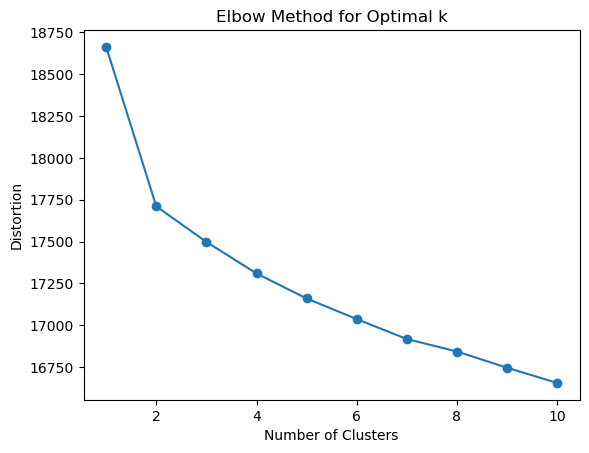

In [33]:
unique_vals = inspections_citations_notnull['narrative'].unique()
plot_kcluster_elbow(unique_vals)

In [34]:
# Using topic modeling as EDA tool
df = topic_modeling(inspections_citations_notnull, text_column='narrative', num_topics=10)

for cluster_id in df['topic_cluster'].unique():
    cluster_rows = df[df['topic_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_rows['narrative'])
    print()

Cluster 2:
2         At the south farm, a goat was observed to jump...
40        According to facility observational and/or hea...
49        Two marmosets (male 601 858 271, female 844 82...
88        The bales of hay being fed to 66 ewes and 65 l...
92        In the enclosure housing 8 sheep at the Multip...
                                ...                        
112707    A 3-week old Teddy was observed to be sticking...
112804    Potable water is not being continuously provid...
112889    The outdoor enclosure housing two adult common...
112988    Per the licensee, on 10/16/2023 a 3 month old ...
113002    A section of chicken wire attached to the goat...
Name: narrative, Length: 5335, dtype: object

Cluster 7:
4         Two bottles of Heparin (one partially used, on...
34        One expired bottle of Isoflourane (expiration ...
42        In August 2015, a cynomolgus macaque placed un...
44        A review of facility records for the marmoset ...
47        A protocol involving s

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [35]:
df['topic_cluster'].value_counts()

topic_cluster
0    6674
2    5335
4    4036
7    3018
8    1619
6     350
1      44
3       4
5       2
Name: count, dtype: int64

In [36]:
df[df['topic_cluster'] == 4]['narrative'].tolist()

['***Facility personnel did not perform adequate daily observations of two sheep, ID #7070 and #8020, by failing to\ncommunicate their health conditions to the attending veterinarian.\nWritten daily observations provided by the facility indicate that on 06/03/18 sheep #8020 “had no interest in food.”\nOn 06/09/18, sheep #8020 “wasn’t eating and was laying down.” On 06/10/18 he was treated for urinary calculi,\nhowever a facility representative stated that the sheep had not been examined by or diagnosed by a veterinarian.\nOn 06/11/18, he was observed to be down and "didn\'t get up this morning." At the 1PM observation later that day,\nrecords indicate that “8020 died due to complications from urinary calculi.”\nWritten daily observations provided by the facility indicate that from 06/04/18-06/25/18, ewe #7070 had been\nvomiting almost on a daily basis. A facility representative informed the APHIS inspector that he had been feeding\nher alfalfa pellets separately from the herd, as she w

In [37]:
# Repeating with higher maximum clusters to extract additional obvious groups
df = topic_modeling(inspections_citations_notnull, text_column='narrative', num_topics=15)

# Print clusters
for cluster_id in df['topic_cluster'].unique():
    cluster_rows = df[df['topic_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_rows['narrative'])
    print()

Cluster 2:
2         At the south farm, a goat was observed to jump...
40        According to facility observational and/or hea...
49        Two marmosets (male 601 858 271, female 844 82...
88        The bales of hay being fed to 66 ewes and 65 l...
92        In the enclosure housing 8 sheep at the Multip...
                                ...                        
112893    On November 2nd, 2023 a young child was bitten...
112950    A member of the public was bitten by an Africa...
112988    Per the licensee, on 10/16/2023 a 3 month old ...
113002    A section of chicken wire attached to the goat...
113042    During an inspection at RDU airport, the inspe...
Name: narrative, Length: 5752, dtype: object

Cluster 7:
4         Two bottles of Heparin (one partially used, on...
34        One expired bottle of Isoflourane (expiration ...
73        **Several expired medications were found in th...
101       Several expired or improperly labeled medicati...
178       The USDA Annual Report

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [38]:
df['topic_cluster'].value_counts()

topic_cluster
0     6706
2     5752
4     3152
8     1957
11    1551
7      699
12     673
10     255
14     141
5      107
3       73
13      14
1        1
9        1
Name: count, dtype: int64

In [39]:
df[df['topic_cluster'] == 5]['narrative'].tolist()

['A cat traveling on a United flight from Ontario to Kansas City, with a stop in San Francisco was inspected at the\nUnited Cargo office. The waybill number was 016-51451396. On inspection it was discovered that the Owner(cid:25)s\nFeeding and Watering Instructions attached to the crate had not been completed. There was no documentation as\nto when the animal was last offered food and water, nor as to the feeding and watering instructions for the next 24\nhours.\nCarriers should not accept dogs and cats for transport unless the consignor certifies in writing to the carrier that the\nanimal was offered food and water during the 4 hours before delivery for transport. This requirement helps to assure\nthat the animal will receive adequate care during transport. Steps should be taken to ensure that all personnel\naccepting animals on behalf of United understand and abide by this requirement.\nTo be corrected from this time forward.\nAn exit interview was conducted with a United Cargo offic

In [40]:
# Repeating with higher maximum clusters to extract additional obvious groups
df = topic_modeling(inspections_citations_notnull, text_column='narrative', num_topics=20)

# Print clusters
#for cluster_id in df['topic_cluster'].unique():
#    cluster_rows = df[df['topic_cluster'] == cluster_id]
#    print(f"Cluster {cluster_id}:")
#    print(cluster_rows['narrative'])
#    print()

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [41]:
#df['topic_cluster'].value_counts()

In [42]:
#df[df['topic_cluster'] == 13]['narrative'].tolist()

## Heat/Temperature

Exploratory data analysis for specifically heat/temperature. 

### Notes 

- At 419 narratives, the heat/temperature flag has just 2% coverage of total narratives
    - TFIDF values for heat and temperature are also low, not in top ~300 terms <br><br>

- Mention of “heat” does not always mean the inspection revealed the animal was subject to overheating/excessive cooling.
    - Why? “Overheating” or "heat" is often a sub-item in a standardized list of ways an animal should not be treated. The sentiment roughly reads (the exact phrasing changes; possibly a sentence included in some guiding inspection document): “all handling of animals should be done as carefully as possible in a manner that does not cause **overheating**, physical harm, or unnecessary discomfort.”
        - 144 narratives contain the substring “carefully as possible in a manner that does not cause” (likely an undercount of the sub-item phenomenon)
    - Additionally, heat/temperature can also be used to describe an outcome to prevent, for example: "... repair the electrical outlet and then determine the capability of the unit to insure in can store food at the proper **temperature** and humidity."<br><br>

- Filtering narratives according to mention of heat/temperature still results in diverse inspection findings/recommendations
     - Animals suffered from overheating 
         - E.g. "The initial corrective action was insufficient to maintain the appropriate temperature\nfor hamsters, leading to an ambient temperature of >85 degrees for more than 12 hour" 
        - "On May 2, 2022, four Damaraland mole rats were found dead in their enclosures. According to facility personnel, an\nelectric space heater that was being used to provide supplemental heat for the animals was somehow placed under the\nmetal rack holding the enclosures resulting in the animals overheating."
    - Improper sanitization procedures
        - "The facility could not verify that the Guinea Pig primary enclosures are being adequately sanitized. The facility currently\nuses temperature-tapes to verify that the correct temperature (180 degrees Fahrenheit) is reached by the automated\nwashing systems. There have been numerous failures of this system to reach the required temperatures and numerous\nadditional weeks where the staff has failed to follow their internal procedures to test the temperatures in order to verify\nthat the washing system is functioning properly.\nTemperature tape readings record whether the cage wash reaches the required 180 degrees."
    
### Questions
- What is the purpose behind identifying narratives involving heat/temperature?
    - A frequently occuring inspection theme is flaws in animals' enclosures. Inadequate enclosures can lead to animal overheating/underheating. Should the flag focus on the outcome (overheating/underheating) or the initial failure in enclosure maintenance/construction?
- What are more useful flags for assisting future analysis of this dataset? 
- Should flags aim for broadness/coverage? Or should flags identify very specific/rare phenomenons?

In [43]:
df['narrative'].notnull().sum()

21082

In [44]:
print(len(df[df['narrative'].str.contains('heat | temperature')]['narrative'].tolist()))

424


In [45]:
419/20842 * 100

2.0103636887054988

In [46]:
df[df['narrative'].str.contains('heat | temperature')]['narrative'].tolist()[0:10]

["In August 2015, a cynomolgus macaque placed under anesthesia for a study procedure was observed to have a\nlow body temperature. In order to normalize the animal's core temperature during the procedure, a staff member\nwas directed by a veterinarian to use a hot air source; however, the nozzle of this hot air source was inappropriately\nplaced in a location which subsequently led to thermal injuries and later, euthanasia.\nIt is the responsibility of the research facility to ensure that all scientists, research technicians, animal technicians,\nand other personnel involved in animal care, treatment, and use are qualified to perform necessary or directed\nduties. This responsibility shall be fulfilled in part through the provision of training and appropriate instruction to\nthose personnel.\nCorrective measures were taken, including but not limited to, retraining of all involved staff and observation of\ntechniques by veterinary staff.\nThis item has been corrected by the facility.",


In [47]:
#df['narrative_no_nums'] = df['narrative'].str.replace(r'\d+', '', regex=True)
#df[df['narrative_no_nums'].str.contains('2')]['narrative_no_nums']

# Tokenize the text in the 'text' column
df['tokenized_text'] = df['narrative'].apply(lambda x: word_tokenize(x.lower()))

# Train Word2Vec model
model = Word2Vec(sentences=df['tokenized_text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/3606272378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['narrative'].apply(lambda x: word_tokenize(x.lower()))


In [48]:
# Find words related to "heat" or "temperature" or "hot"
similar_heat = model.wv.most_similar('heat', topn=50)
similar_temperature = model.wv.most_similar('temperature', topn=50)
similar_hot = model.wv.most_similar('hot', topn=50)

In [49]:
print("Words related to 'hot':", [word for word, score in similar_hot])

Words related to 'hot': ['chicken', 'deteriorating', 'encasement', 'apart', 'heating', 'hose', 'strands', 'hardware', '180', 'buckets', 'frozen', 'loose', 'bowls', 'carpet', 'pooling', 'humid', 'significantly', 'screws', 'low', 'twine', 'degrade', 'cloth', 'branches', 'bolts', 'barrel', 'pieces', 'rusty', 'waffle', 'exposed', 'stanchions', 'mud', '4-6', 'ice', 'outward', 'too', 'inward', 'chewed', 'torn', 'exposing', 'high', 'rock', 'rubber', 'branch', 'unprotected', 'upwards', 'rotten', 'breaking', 'brush', 'underneath', 'dirty']


In [50]:
print("Words related to 'heat':", [word for word, score in similar_heat])

Words related to 'heat': ['cold', 'weather', 'rain', 'lamps', 'wind', 'extremes', 'inclement', 'lamp', 'extreme', 'protection', 'temperatures', 'exposure', 'breaks', 'snow', 'ventilation', 'break', 'levels', 'ambient', 'heating', 'bulb', 'freezing', 'low', 'sun', 'wind/rain', 'becoming', 'chills', 'temperature', 'rains', 'cords', 'passage', 'precipitation', 'natural', 'systems', 'shelter', 'reduced', 'unprotected', 'cool', 'shade', 'sunlight', 'warm', 'artificial', 'winds', 'range', 'environments', 'themselves', 'slipping', 'falling', 'comfortably', 'preventing', 'spill']


In [51]:
print("Words related to 'temperature':", [word for word, score in similar_temperature])

Words related to 'temperature': ['ambient', 'temperatures', 'humidity', 'degrees', 'fahrenheit', 'f.', '85', 'extremes', 'low', 'exceed', 'cold', 'ventilation', '35', 'heater', 'heat', '22.6', 'levels', '94', 'air', 'f', 'channel', 'below', 'rise', 'thermometer', 'cooled', 'freezing', 'weather', 'range', 'deg', '50', 'heated', '98.5', '60', '46.7', '52.3', '35f', '79.2f', 'predicted', '90°f', 'night', 'rain', 'fluctuations', '53.2', 'national', 'climate', 'kestrel', '54.7', 'bedding', 'lighting', '87']


### Heat/Temperature Topic Modeling

In [52]:
# Topic modeling for just narratives containing heat, temperature

# Placeholder temperature/heat keywords
temp_keywords = ['heat', 'temperature', 'humid', 'cold', 'weather', 'wind', 'rain', 'inclement', 'extremes', 'hypothermia', 
                'cooling', 'freezing', 'ambient', 'chill', 'fahrenheit', 'degrees', 'weather', 'inclement']

In [53]:
# Create flag column
inspections_citations_notnull['heat_temp_flag'] = citations['narrative'].apply(lambda x: any(word in x.lower() for word in temp_keywords))

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/3886875396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspections_citations_notnull['heat_temp_flag'] = citations['narrative'].apply(lambda x: any(word in x.lower() for word in temp_keywords))


In [54]:
inspections_citations_notnull['heat_temp_flag'].value_counts(normalize=True)

heat_temp_flag
False    0.87847
True     0.12153
Name: proportion, dtype: float64

In [55]:
heat_temp_narratives = inspections_citations_notnull[inspections_citations_notnull['heat_temp_flag'] == True]

In [56]:
# Using topic modeling as EDA tool
df = topic_modeling(heat_temp_narratives, text_column='narrative', num_topics=10)

#for cluster_id in df['topic_cluster'].unique():
#    cluster_rows = df[df['topic_cluster'] == cluster_id]
#    print(f"Cluster {cluster_id}:")
#    print(cluster_rows['narrative'])
#    print()

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [57]:
df['topic_cluster'].value_counts()

topic_cluster
1    452
6    226
9    165
3      1
4      1
Name: count, dtype: int64

In [58]:
df[df['topic_cluster'] == 5]['narrative'].tolist()

[]

### Filtering for Critical and Direct Citations

In [59]:
df['kind'].value_counts(dropna=False)

kind
NaN         746
Critical     58
Direct       41
Name: count, dtype: int64

In [60]:
# Web critical: 111 total
df['web_critical'].value_counts(dropna=False)

web_critical
0    740
1     84
2     18
3      2
4      1
Name: count, dtype: int64

In [61]:
# Web direct: 61 total
df['web_direct'].value_counts(dropna=False)

web_direct
0    795
1     39
2      9
3      1
4      1
Name: count, dtype: int64

In [62]:
df['pdf_insp_type'].value_counts(dropna=False)

pdf_insp_type
ROUTINE INSPECTION       633
ATTEMPTED INSPECTION     164
FOCUSED INSPECTION        33
RE-LICENSE INSPECTION     14
NEW SITE INSPECTION        1
Name: count, dtype: int64

In [63]:
df[df['topic_cluster'] == 9]['pdf_insp_type'].value_counts(dropna=False)

pdf_insp_type
ATTEMPTED INSPECTION    160
ROUTINE INSPECTION        5
Name: count, dtype: int64

In [64]:
df[df['web_critical'] != 0]['narrative'].tolist()

['A review of facility records for the marmoset (microchip # 004-004-103) which died on 23 Dec 2015 following a\nprocedure performed on 21 Dec 2015 found that the PI did not follow the approved protocol in regards to IV catheter\nplacement and IV fluid support as well as amounts and routes of anesthetic and paralytic drugs used during the\nprocedure. The PI did not follow the instructions of the veterinarian and the procedure continued 10 hours rather\nthan the veterinarian recommended 2-3 hours. The animal subsequently died ~33 hours post procedure.\nThe research facility must ensure that the attending veterinarian has the appropriate authority to ensure adequate\nveterinary care is provided and to oversee the adequacy of other aspects of animal care and use. Failure to follow\napproved protocols and veterinary recommendations can result in outcomes such as occurred with this animal.\nPrior to the inspection, changes to the protocol were made to incorporate corrective measures, and ne

In [65]:
critical_direct_narratives = inspections_citations_notnull[(inspections_citations_notnull['kind'].isin(['Critical', 'Direct']) |
                                                            (inspections_citations_notnull['web_direct'] != 0) |
                                                            (inspections_citations_notnull['web_critical'] != 0))]

In [66]:
critical_direct_narratives['kind'].value_counts()

kind
Direct      1003
Critical     711
Name: count, dtype: int64

In [67]:
critical_direct_narratives['web_critical'].value_counts()

web_critical
0    1236
1    1145
2     162
3      44
4      14
5       4
6       1
8       1
Name: count, dtype: int64

In [68]:
# Using topic modeling as EDA tool
df = topic_modeling(critical_direct_narratives, text_column='narrative', num_topics=10)

#for cluster_id in df['topic_cluster'].unique():
#    cluster_rows = df[df['topic_cluster'] == cluster_id]
#    print(f"Cluster {cluster_id}:")
#    print(cluster_rows['narrative'])
#    print()

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_33437/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)
